### CAMUS Dataset Preprocessing, Landmark Extraction, and DVF Calculation

#### Source: (https://www.kaggle.com/code/sontungtran/camus-eda/)
- The below code for reading the data is taken from the source.
- The data is read from the train and test folders using SimpleITK.
- The data is then converted to numpy arrays and stored in a dictionary,
- along with the respective metadata for each image.
- The data for each patient can be accessed by indexing the train_iter and 
test_iter dictionaries with the patient ID.
- Also includes a function to display the image sequences, and for resizing
- the images to a consistent size and adding salt and pepper noise augmentation.

In [54]:
import os
import cv2 as cv
import numpy as np 
import pandas as pd 
import time
from contextlib import contextmanager # timer
from functools import partial

import seaborn as sns
import SimpleITK as sitk
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle

from skimage.transform import rescale, resize

import torch
from torch.utils import data
from torch.utils.data import DataLoader, Dataset

data_dir = 'C:/Users/BazB1/Desktop/Work/in2research/Data/CAMUS_public/database/'

# Stolen from a Kaggle Kernel
# https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s/comments
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
'''
Doc: Take out image one by one and apply transformations upon __getitem__
'''

class CamusIterator(Dataset):
    def __init__( 
        self, 
        data_type='train', 
        global_transforms=[], 
        augment_transforms=[]
    ):
        super(CamusIterator, self).__init__()
        
        train_file='C:/Users/BazB1/Desktop/Work/in2research/Data/CAMUS_public/database/training'
        test_file='C:/Users/BazB1/Desktop/Work/in2research/Data/CAMUS_public/database/testing'
        
        if data_type == 'train':
            data_file = train_file
        elif data_type == 'test':
            data_file = test_file
        else:
            raise Exception('Wrong data_type for CamusIterator')
            
        self.data_type = data_type
        self.data_file = data_file
        self.global_transforms = global_transforms
        self.augment_transforms = augment_transforms
    
    def __read_image( self, patient_file, suffix ):
        image_file = '{}/{}/{}'.format( self.data_file, patient_file, patient_file+suffix )
        # Stolen from a StackOverflow answer
        # https://stackoverflow.com/questions/37290631/reading-mhd-raw-format-in-python
        image = sitk.GetArrayFromImage( sitk.ReadImage(image_file, sitk.sitkFloat32) )
        return image

    def __read_info( self, data_file ):
        info = {}
        with open( data_file, 'r' ) as f:
            for line in f.readlines():
                info_type, info_details = line.strip( '\n' ).split( ': ' )
                info[ info_type ] = info_details
        return info

    def __len__( self ):
        return len( os.listdir(self.data_file) )
    
    def __getitem__( self, index ):
        patient_file = 'patient{}'.format( f'{index+1:04}' ) # patient{0001}, patient{0002}, etc
        
        image_2CH_ED = self.__read_image( patient_file, '_2CH_ED.mhd' )
        image_2CH_ES = self.__read_image( patient_file, '_2CH_ES.mhd' )
        image_4CH_ED = self.__read_image( patient_file, '_4CH_ED.mhd' )
        image_4CH_ES = self.__read_image( patient_file, '_4CH_ES.mhd' )
        image_2CH_sequence = self.__read_image( patient_file, '_2CH_sequence.mhd' )
        image_4CH_sequence = self.__read_image( patient_file, '_4CH_sequence.mhd' )
        
        if self.data_type == 'train':
            image_2CH_ED_gt = self.__read_image( patient_file, '_2CH_ED_gt.mhd' )
            image_2CH_ES_gt = self.__read_image( patient_file, '_2CH_ES_gt.mhd' )
            image_4CH_ED_gt = self.__read_image( patient_file, '_4CH_ED_gt.mhd' )
            image_4CH_ES_gt = self.__read_image( patient_file, '_4CH_ES_gt.mhd' )

        info_2CH = self.__read_info( '{}/{}/{}'.format(self.data_file, patient_file, 'Info_2CH.cfg') )
        info_4CH = self.__read_info( '{}/{}/{}'.format(self.data_file, patient_file, 'Info_4CH.cfg') )
        
        if self.data_type == 'train':
            data = {
                'patient': patient_file,
                '2CH_ED': image_2CH_ED,
                '2CH_ES': image_2CH_ES,
                '4CH_ED': image_4CH_ED,
                '4CH_ES': image_4CH_ES,
                '2CH_sequence': image_2CH_sequence,
                '4CH_sequence': image_4CH_sequence,
                '2CH_ED_gt': image_2CH_ED_gt,
                '2CH_ES_gt': image_2CH_ES_gt,
                '4CH_ED_gt': image_4CH_ED_gt,
                '4CH_ES_gt': image_4CH_ES_gt,
                'info_2CH': info_2CH,    # Dictionary of infos
                'info_4CH': info_4CH}    # Dictionary of infos
        elif self.data_type == 'test':
            data = {
                'patient': patient_file,
                '2CH_ED': image_2CH_ED,
                '2CH_ES': image_2CH_ES,
                '4CH_ED': image_4CH_ED,
                '4CH_ES': image_4CH_ES,
                '2CH_sequence': image_2CH_sequence,
                '4CH_sequence': image_4CH_sequence,
                'info_2CH': info_2CH,   # Dictionary of infos
                'info_4CH': info_4CH}   # Dictionary of infos
        
        # Transforms
        for transform in self.global_transforms:
            data = transform(data)
        for transform in self.augment_transforms:
            data = transform(data)
            
        return data

    def __iter__( self ):
        for i in range( len(self) ):
            yield self[ i ]

class ResizeImagesAndLabels(object):
    ''' 
    Ripped out of Prof. Stough's code 
    '''
    
    def __init__(self, size, fields=['2CH_ED', '2CH_ES', '4CH_ED', '4CH_ES',
                                    '2CH_ED_gt', '2CH_ES_gt', '4CH_ED_gt', '4CH_ES_gt']):
        self.size = size
        self.fields = fields
        
    def __call__(self, data):
        for field in self.fields:            
            # transpose to go from chan x h x w to h x w x chan and back.
            data[field] = resize(data[field].transpose([1,2,0]), 
                                self.size, mode='constant', 
                                anti_aliasing=True)
            data[field] = data[field].transpose( [2,0,1] )      

        return data

class AddSaltPepper(object):
    '''
    Ripped out of Prof. Stough's code
    
    "Class to augment the inputs with salt and pepper noise with some frequency.
    Assume already normalized image."
    '''
    def __init__( self, freq = 0.0, fields=['2CH_ED', '2CH_ES', '4CH_ED', '4CH_ES'] ):
        assert freq >= 0.0 and freq <= 1.0,\
            'AddSaltPepper: freq must be in [0,1] ({})'.format( freq )
        
        self.freq = freq
        self.fields = fields
        
    def __call__(self, data):        
        for field in self.fields:
            noise = np.random.randint( 0, 2, size=data[field].shape ).astype( np.float32 )
            data[field] = np.where( np.random.random_sample( data[field].shape )<=self.freq, 
                            noise, data[field] )
        
        return data

# For displaying image sequences
def display_image(image):
    # Stolen from a StackOverflow answer
    # https://stackoverflow.com/questions/37290631/reading-mhd-raw-format-in-python
    
    plt.figure(figsize=(20,16))
    plt.gray()
    plt.subplots_adjust(0,0,1,1,0.01,0.01)
    for i in range(image.shape[0]):
        plt.subplot(5,6,i+1), plt.imshow(image[i]), plt.axis('off')
        # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
    plt.show()

# Batch size need to be 1 to avoid RuntimeError: Sizes of tensors must match except in dimension 0.
# https://medium.com/@yvanscher/pytorch-tip-yielding-image-sizes-6a776eb4115b
param_Loader = {'batch_size': 1,
                'shuffle': True,
                'num_workers': 12}

global_transforms = [
    ResizeImagesAndLabels(size=[256, 256])
]
augment_transforms = [
    #AddSaltPepper(freq = .1)
]

train_iter = CamusIterator(
    data_type='train',
    global_transforms=global_transforms,
    augment_transforms=augment_transforms,
)

test_iter = CamusIterator(
    data_type='test',
    global_transforms=global_transforms,
    augment_transforms=augment_transforms,
)

print('Number of Train Samples: ', len(train_iter))
print('Number of Test Samples: ', len(test_iter))

data = DataLoader(train_iter, **param_Loader)

Number of Train Samples:  450
Number of Test Samples:  51


### The below code is authored by me:
- Author: Basil Batov
- First created: 14-07-2023

##### Demonstration of how to access the patient info for a particular patient

In [55]:
patient_info = train_iter[0]['info_2CH']
print(patient_info)

{'ED': '1', 'ES': '18', 'NbFrame': '18', 'Sex': 'F', 'Age': '56', 'ImageQuality': 'Good', 'LVedv': '94.0', 'LVesv': '34.6', 'LVef': '63.2'}


##### Demonstration of variation in sequence length and image size between patients

In [56]:
patient0 = train_iter[0]['2CH_sequence'].shape
patient6 = train_iter[6]['2CH_sequence'].shape
print(f"Patient 0 2CH Sequence Length: {patient0[0]}, Height: {patient0[1]}, Width: {patient0[2]}")
print(f"Patient 6 2CH Sequence Length: {patient6[0]}, Height: {patient6[1]}, Width: {patient6[2]}")
# TODO: Normalise images to same shape and sequence length - depends on the model and if it can handle variable length sequences.

Patient 0 2CH Sequence Length: 18, Height: 778, Width: 549
Patient 6 2CH Sequence Length: 22, Height: 1038, Width: 630


##### Demonstration of displaying a patient image sequence

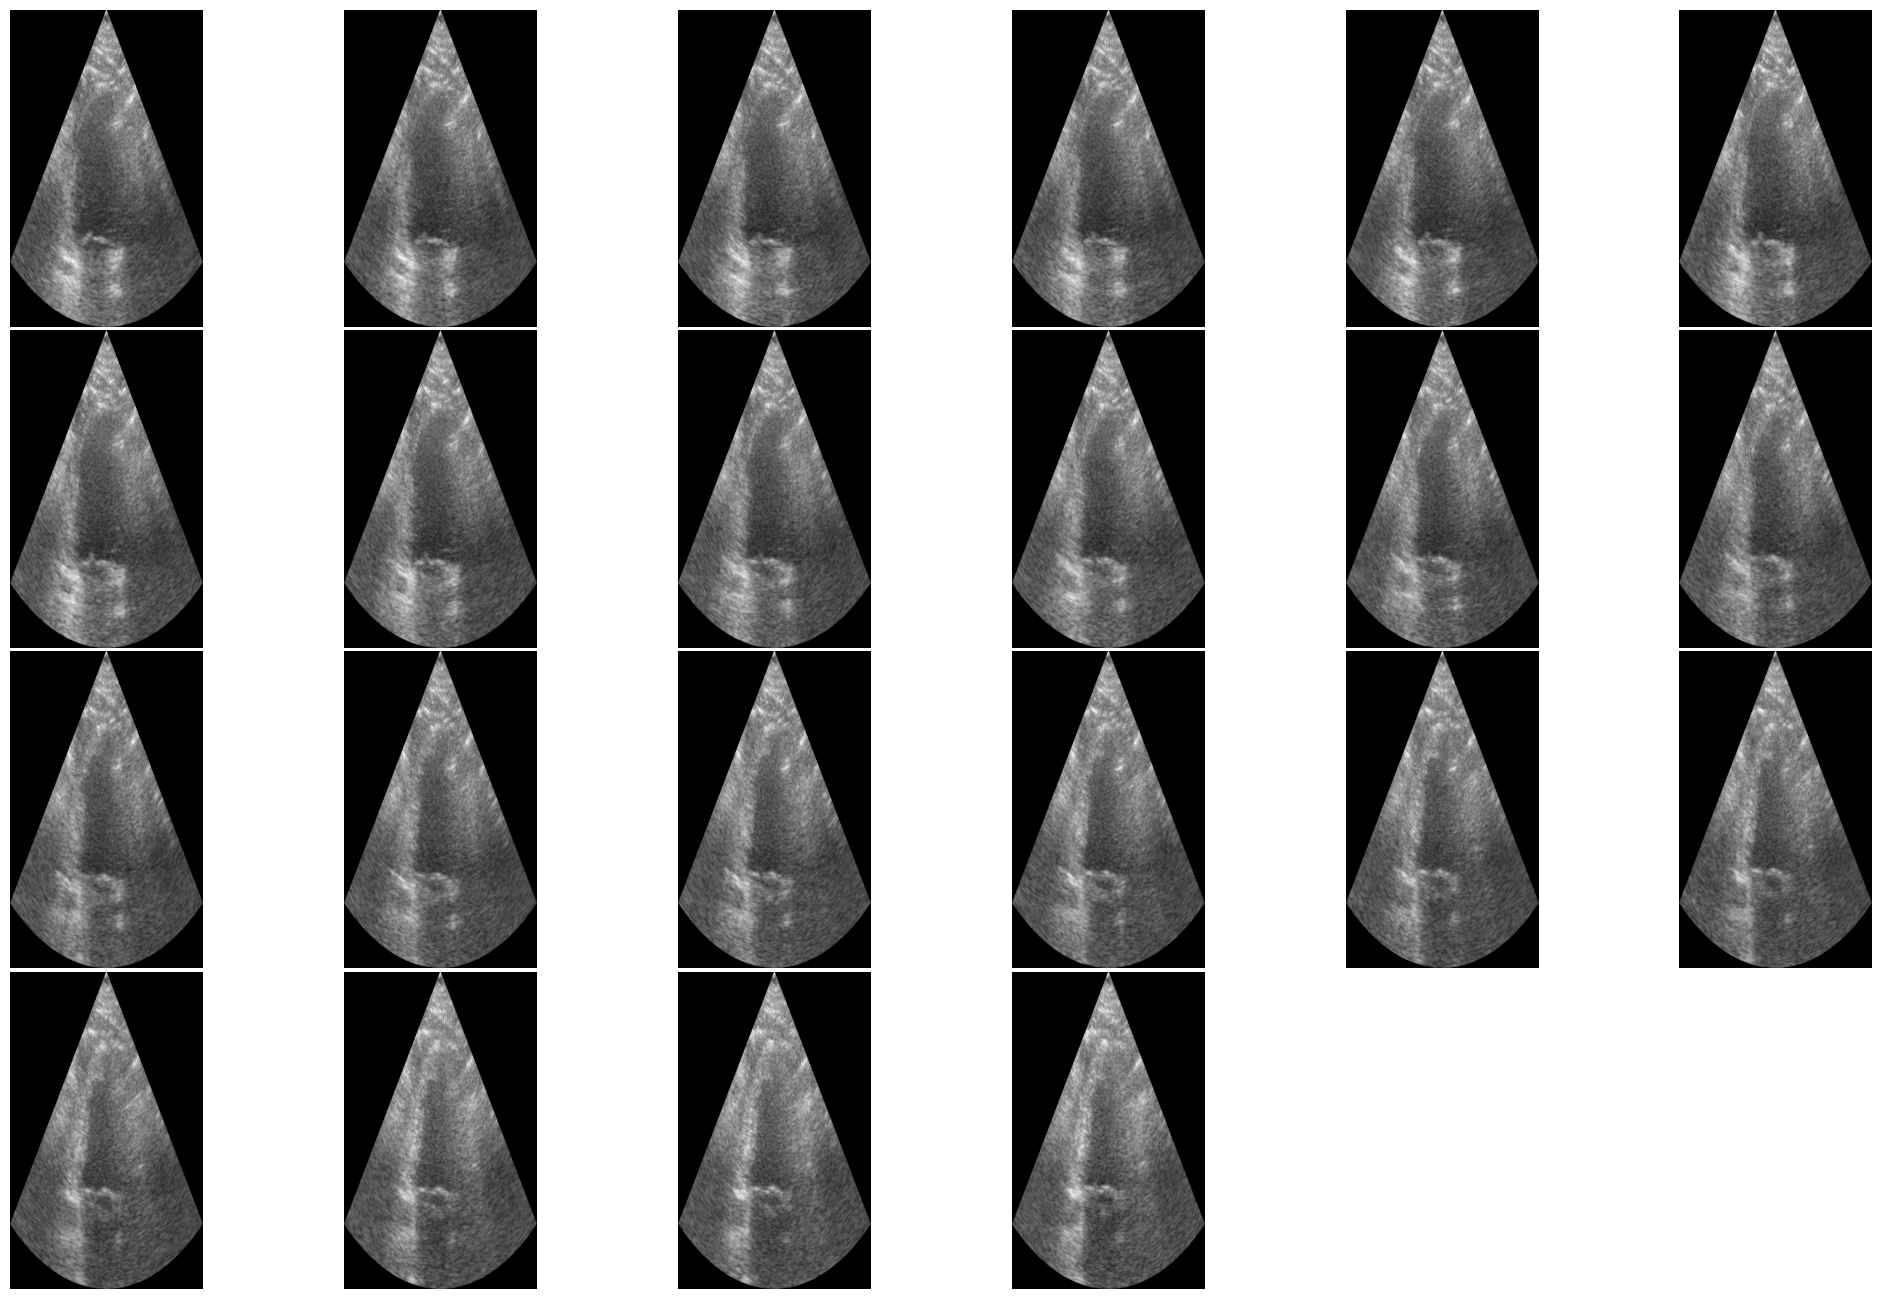

In [57]:
display_image(train_iter[6]['2CH_sequence'])

- The segmentation ground truths (gt) only exist for the ED and ES frames.
- ED is always frame 1, and ES always the last frame - so can evaluate tracking error on the last frame.
- Sequence length varies by patient and therefore the ES/last frame.
- So the ground truth for the first frame will be initially fed into the model then tracked for all frames until the last/ES frame, gt used to evaluate.
- TODO: Maybe do data analysis and plot of ES frame numbers/sequence length for all patients. 

Text(0.5, 1.0, 'End Frame Segmentation GT')

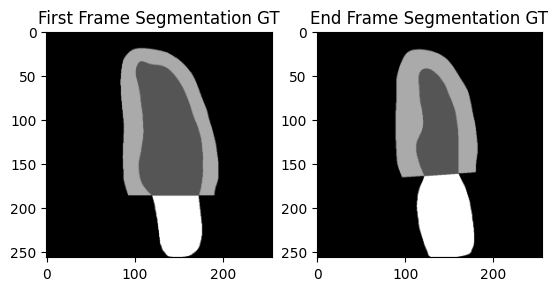

In [58]:
patient = train_iter[0] # select a particular patient
initial_frame = patient['2CH_ED'][0] # same as patient['2CH_sequence'][0]
initial_frame_gt = patient['2CH_ED_gt'][0] # (no sequence of ground truth)
end_frame = patient['2CH_ES'][0] # same as patient['2CH_sequence'][-1]
end_frame_gt = patient['2CH_ES_gt'][0]
"""
# For testing that displacement will be 0 if using the same start and end frame
end_frame = patient['2CH_ED'][0]
end_frame_gt = patient['2CH_ED_gt'][0]
"""

plt.figure()
plt.subplot(1,2,1)
plt.title('First Frame Segmentation GT')
plt.imshow(initial_frame_gt)
plt.subplot(1,2,2)
plt.imshow(end_frame_gt)
plt.title('End Frame Segmentation GT')
# Adjust the spacing between subplots
#plt.subplots_adjust(wspace=0.25)

##### Demonstration of displaying the first and last frame in a patient image sequence

Text(0.5, 1.0, 'End Frame')

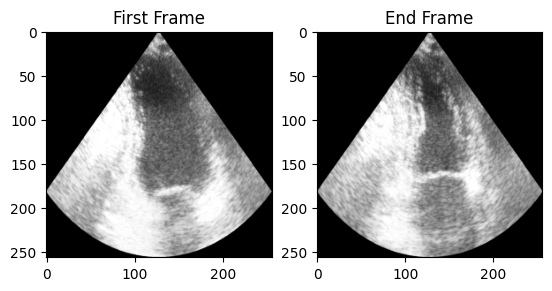

In [59]:
plt.figure()
plt.subplot(1,2,1)
plt.title('First Frame')
plt.imshow(initial_frame)
plt.subplot(1,2,2)
plt.imshow(end_frame)
plt.title('End Frame')

In [60]:
print(initial_frame.shape)
print(initial_frame.dtype)

(256, 256)
float32


Start Frame Contour Length:  579
End Frame Contour Length 584


Text(0.5, 1.0, 'End Frame Contour')

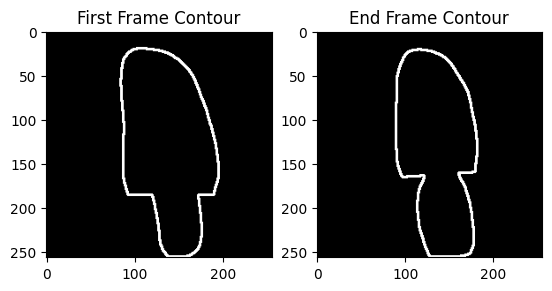

In [107]:
# Convert to uint8 - the frames are float32 so need to convert to uint8 for cv2
initial_frame = cv.convertScaleAbs(initial_frame)
initial_frame_gt = cv.convertScaleAbs(initial_frame_gt)
end_frame = cv.convertScaleAbs(end_frame)
end_frame_gt = cv.convertScaleAbs(end_frame_gt)

# Detect contours
startCnts,_= cv.findContours(initial_frame_gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
startMarkers = np.zeros((initial_frame.shape[0], initial_frame.shape[1]))
endCnts,_= cv.findContours(end_frame_gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
endMarkers = np.zeros((end_frame.shape[0], end_frame.shape[1]))
print("Start Frame Contour Length: ",len(startCnts[0]))
print("End Frame Contour Length", len(endCnts[0]))

# Plot contours
t = 2 # thickness
plt.figure()
plt.subplot(1,2,1)
cv.drawContours(startMarkers, startCnts, -1, (255, 0, 0), t)
plt.imshow(startMarkers)
plt.title('First Frame Contour')

plt.subplot(1,2,2)
cv.drawContours(endMarkers, endCnts, -1, (255, 0, 0), t)
plt.imshow(endMarkers)
plt.title('End Frame Contour')

# When computing gt landmark - if see variability in landmarks - think of as higher degree of freedom
# Sequences of images - how to connect them together? Focus just on one image at a time for now.

In [62]:
# Select a set of landmarks that are evenly distributed around the contours
# For a given contour, select every nth point
step = 10 # every nth point
startLandmarks = []
for i in range(0, len(startCnts[0]), step):
    startLandmarks.append(startCnts[0][i][0])
startLandmarks = np.array(startLandmarks)
print(startLandmarks.shape)

endLandmarks = []
for i in range(0, len(endCnts[0]), step):
    endLandmarks.append(endCnts[0][i][0])
endLandmarks = np.array(endLandmarks)
print(endLandmarks.shape)

(58, 2)
(59, 2)


##### Plot the landmarks over the original image

Text(0.5, 1.0, 'End Frame Landmarks')

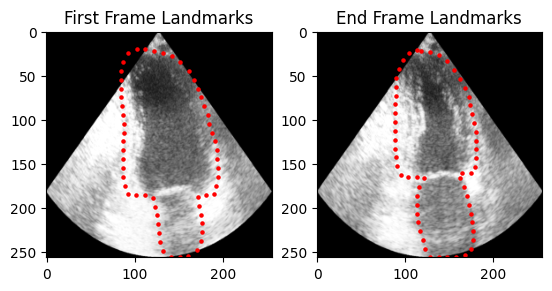

In [108]:
plt.figure()

# Plot the landmarks on the initial frame
plt.subplot(1,2,1)
plt.imshow(initial_frame)
plt.scatter(startLandmarks[:,0], startLandmarks[:,1], c='r', s=5) # s is size of marker
plt.title('First Frame Landmarks')

# Plot the landmarks on the end frame
plt.subplot(1,2,2)
plt.imshow(end_frame)
plt.scatter(endLandmarks[:,0], endLandmarks[:,1], c='r', s=5)
plt.title('End Frame Landmarks')

##### Establish correspondence between landmarks in the start and end frames based on their spatial proximity
- A landmark in the start frame is paired with the landmark in the end frame that is closest to it.
- Alternatively could use a feature-based approach to establish correspondence between landmarks e.g. SIFT, SURF, ORB, etc.


In [64]:
from scipy.spatial import distance

def match_landmarks(start_landmarks, end_landmarks, max_distance_threshold):
    """
    Match landmarks from the start and end frames based on spatial proximity.

    Args:
        start_landmarks (ndarray): Array of start frame landmarks with shape (N, 2).
        end_landmarks (ndarray): Array of end frame landmarks with shape (M, 2).
        max_distance_threshold (float): Maximum distance allowed for a valid landmark match.

    Returns:
        ndarray: Array of matched start frame landmarks with shape (K, 2),
                 where K <= min(N, M) and represents the number of matched landmarks.
        ndarray: Array of matched end frame landmarks with shape (K, 2),
                 corresponding to the matched start frame landmarks.
    """
    matched_start_landmarks = []
    matched_end_landmarks = []

    for start_landmark in start_landmarks:
        # Calculate distances between the start landmark and all end landmarks
        distances = distance.cdist([start_landmark], end_landmarks)[0]
        
        # Find the minimum distance and corresponding index
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)

        # If the minimum distance is within the threshold, consider it as a valid match
        if min_distance <= max_distance_threshold:
            matched_start_landmarks.append(start_landmark)
            matched_end_landmarks.append(end_landmarks[min_distance_index])

    return np.array(matched_start_landmarks), np.array(matched_end_landmarks)

(55, 2)
(55, 2)
Matched Start Landmarks:
[[103  19]
 [ 93  24]
 [ 87  34]
 [ 85  44]
 [ 84  54]
 [ 85  64]
 [ 85  74]
 [ 86  84]
 [ 87  94]
 [ 88 104]
 [ 88 114]
 [ 87 124]
 [ 87 134]
 [ 87 144]
 [ 87 154]
 [ 87 164]
 [ 89 174]
 [102 185]
 [112 185]
 [121 188]
 [123 198]
 [125 208]
 [127 218]
 [128 228]
 [129 238]
 [132 248]
 [141 255]
 [151 255]
 [161 254]
 [171 247]
 [175 237]
 [176 227]
 [176 217]
 [175 207]
 [173 197]
 [172 187]
 [181 185]
 [195 164]
 [195 154]
 [194 144]
 [193 134]
 [191 124]
 [188 114]
 [185 104]
 [183  94]
 [179  84]
 [175  74]
 [172  64]
 [168  54]
 [162  44]
 [152  34]
 [142  27]
 [132  23]
 [122  21]
 [112  19]]
Matched End Landmarks:
[[104  23]
 [ 97  32]
 [ 93  42]
 [ 93  42]
 [ 90  52]
 [ 90  62]
 [ 90  72]
 [ 89  82]
 [ 89  92]
 [ 89 102]
 [ 89 112]
 [ 89 122]
 [ 89 132]
 [ 90 142]
 [ 91 152]
 [ 95 162]
 [ 95 162]
 [114 186]
 [114 186]
 [114 186]
 [113 196]
 [114 206]
 [115 216]
 [117 226]
 [120 236]
 [128 255]
 [138 255]
 [148 255]
 [158 255]
 [175 246]


Text(0.5, 1.0, 'End Frame Matched Landmarks')

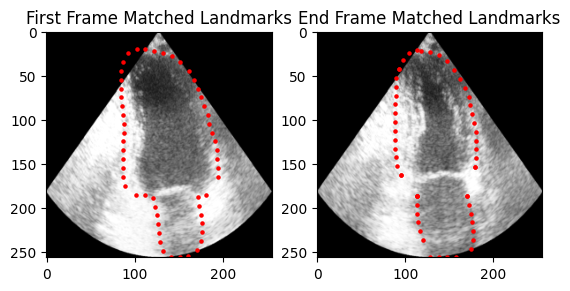

In [109]:
max_distance_threshold = 20 # maximum distance allowed for a valid landmark match

matched_start_landmarks, matched_end_landmarks = match_landmarks(startLandmarks, endLandmarks, max_distance_threshold)
print(matched_start_landmarks.shape)
print(matched_end_landmarks.shape)

print("Matched Start Landmarks:")
print(matched_start_landmarks)

print("Matched End Landmarks:")
print(matched_end_landmarks)

# Plot the matched landmarks on the initial frame
plt.figure()
plt.subplot(1,2,1)
plt.imshow(initial_frame)
plt.scatter(matched_start_landmarks[:,0], matched_start_landmarks[:,1], c='r', s=5)
plt.title('First Frame Matched Landmarks')

# Plot the matched landmarks on the end frame
plt.subplot(1,2,2)
plt.imshow(end_frame)
plt.scatter(matched_end_landmarks[:,0], matched_end_landmarks[:,1], c='r', s=5)
plt.title('End Frame Matched Landmarks')

##### Calculate the displacement vector between each pair of corresponding landmarks

In [70]:
displacement_vectors = matched_end_landmarks - matched_start_landmarks
print("Displacement Vectors:", displacement_vectors)

Displacement Vectors: [[  1   4]
 [  4   8]
 [  6   8]
 [  8  -2]
 [  6  -2]
 [  5  -2]
 [  5  -2]
 [  3  -2]
 [  2  -2]
 [  1  -2]
 [  1  -2]
 [  2  -2]
 [  2  -2]
 [  3  -2]
 [  4  -2]
 [  8  -2]
 [  6 -12]
 [ 12   1]
 [  2   1]
 [ -7  -2]
 [-10  -2]
 [-11  -2]
 [-12  -2]
 [-11  -2]
 [ -9  -2]
 [ -4   7]
 [ -3   0]
 [ -3   0]
 [ -3   1]
 [  4  -1]
 [  2  -1]
 [  1  -1]
 [  0  -1]
 [  0  -1]
 [  0  -1]
 [ -2  -1]
 [-11   1]
 [-16 -11]
 [-16  -1]
 [-14  -1]
 [-12  -1]
 [-10  -1]
 [ -8  -1]
 [ -7  -1]
 [ -7  -1]
 [ -5  -1]
 [ -3  -1]
 [ -4  -1]
 [ -6  -1]
 [ -6  -1]
 [ -4  -1]
 [ -4  -1]
 [ -4  -1]
 [ -4   0]
 [  2   1]]


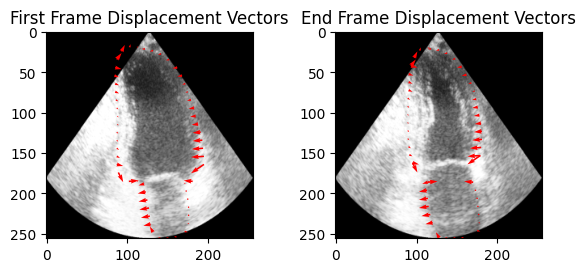

In [114]:
# Plot the displacement vectors on the initial frame
plt.figure()
plt.subplot(1,2,1)
plt.imshow(initial_frame)
plt.quiver(matched_start_landmarks[:,0], matched_start_landmarks[:,1], displacement_vectors[:,0], displacement_vectors[:,1], color='r', scale=1, units='xy')
plt.title('First Frame Displacement Vectors')

# Plot the displacement vectors on the end frame
plt.subplot(1,2,2)
plt.imshow(end_frame)
plt.quiver(matched_end_landmarks[:,0], matched_end_landmarks[:,1], displacement_vectors[:,0], displacement_vectors[:,1], color='r', scale=1, units='xy')
plt.title('End Frame Displacement Vectors')
plt.subplots_adjust(wspace=0.4)

##### Use dense interpolation to estimate displacement vectors for all pixels in the image

In [88]:
from scipy.interpolate import griddata

def generate_dense_dvf(start_landmarks, end_landmarks, image_shape):
    """
    Generate a dense DVF by interpolating the displacement vectors for all pixels in the image.

    Args:
        start_landmarks (ndarray): Array of start frame landmarks with shape (N, 2).
        end_landmarks (ndarray): Array of end frame landmarks with shape (N, 2).
        image_shape (tuple): Shape of the image (height, width).

    Returns:
        ndarray: Dense DVF with shape (height, width, 2), representing the displacement vectors for
                each pixel in the image.
    """
    x = np.arange(image_shape[1])
    y = np.arange(image_shape[0])
    xx, yy = np.meshgrid(x, y)

    # Interpolate the displacement vectors for all pixels in the image
    dense_landmarks = np.vstack((xx.ravel(), yy.ravel())).T 
    dense_displacement_vectors = griddata(start_landmarks, end_landmarks - start_landmarks, dense_landmarks, method='nearest') # method='linear', 'cubic', 'nearest'
    print(dense_displacement_vectors)

    dense_dvf = dense_displacement_vectors.reshape(image_shape[0], image_shape[1], 2)
    return dense_dvf

In [89]:
dense_dvf = generate_dense_dvf(matched_start_landmarks, matched_end_landmarks, initial_frame.shape)
print(dense_dvf)
print(dense_dvf.shape)
print(dense_dvf.dtype)

[[ 6  8]
 [ 6  8]
 [ 6  8]
 ...
 [ 2 -1]
 [ 2 -1]
 [ 2 -1]]
[[[  6   8]
  [  6   8]
  [  6   8]
  ...
  [ -6  -1]
  [ -6  -1]
  [ -6  -1]]

 [[  6   8]
  [  6   8]
  [  6   8]
  ...
  [ -6  -1]
  [ -6  -1]
  [ -6  -1]]

 [[  6   8]
  [  6   8]
  [  6   8]
  ...
  [ -6  -1]
  [ -6  -1]
  [ -6  -1]]

 ...

 [[  6 -12]
  [  6 -12]
  [  6 -12]
  ...
  [  2  -1]
  [  2  -1]
  [  2  -1]]

 [[  6 -12]
  [  6 -12]
  [  6 -12]
  ...
  [  2  -1]
  [  2  -1]
  [  2  -1]]

 [[  6 -12]
  [  6 -12]
  [  6 -12]
  ...
  [  2  -1]
  [  2  -1]
  [  2  -1]]]
(256, 256, 2)
int32


Text(0.5, 1.0, 'Dense DVF Y')

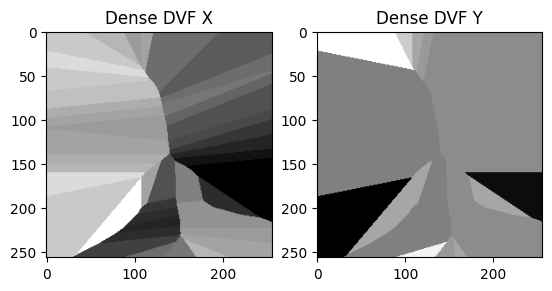

In [121]:
# Plot the dense DVF
plt.figure()
plt.subplot(1,2,1)
plt.imshow(dense_dvf[:,:,0])
plt.title('Dense DVF X')

plt.subplot(1,2,2)
plt.imshow(dense_dvf[:,:,1])
plt.title('Dense DVF Y')

##### Apply the displacement vectors to the start frame to generate the end frame

In [104]:
from scipy.ndimage import map_coordinates
from skimage.transform import warp

# Define the displacement vector field
dense_dvf_x = dense_dvf[:, :, 0]
dense_dvf_y = dense_dvf[:, :, 1]

# Define the coordinates of the output image
h, w = initial_frame.shape[:2]
x, y = np.meshgrid(np.arange(w), np.arange(h))
coords = np.stack([y + dense_dvf_y, x + dense_dvf_x], axis=-1)
coords = np.transpose(coords, (2, 0, 1))

# Warp the image using the displacement vector field
initial_frame_warped = map_coordinates(initial_frame, coords, order=1, mode='nearest') # mode='reflect', 'constant', 'nearest', 'mirror', 'wrap'
#initial_frame_warped = warp(initial_frame, coords, order=1, mode='reflect')

initial_frame_warped = initial_frame_warped.astype(np.uint8)

Text(0.5, 1.0, 'End Frame')

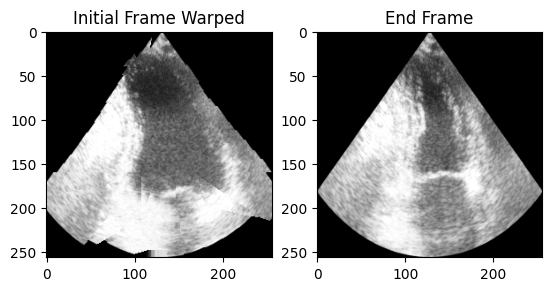

In [105]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(initial_frame_warped)
plt.title('Initial Frame Warped')
plt.subplot(1,2,2)
plt.imshow(end_frame)
plt.title('End Frame')

In [106]:
from skimage.metrics import structural_similarity

# Compute the MSE between the warped image and the end frame
mse = np.mean((initial_frame_warped - end_frame)**2)
print('MSE: ', mse)

# Compute the PSNR between the warped image and the end frame
psnr = 10 * np.log10(255**2 / mse)
print('PSNR: ', psnr)

# Compute the SSIM between the warped image and the end frame
ssim = structural_similarity(initial_frame_warped, end_frame)
print('SSIM: ', ssim)

# Compute the normalised cross correlation between the warped image and the end frame
ncc = np.mean((initial_frame_warped - np.mean(initial_frame_warped)) * (end_frame - np.mean(end_frame))) / \
        (np.std(initial_frame_warped) * np.std(end_frame))
print('NCC: ', ncc)

MSE:  59.66734313964844
PSNR:  30.37343660806265
SSIM:  0.45187070322155054
NCC:  0.8490621446133247


In [ ]:
# TODO: Manual displacement by 2 pixels etc.